## Get data

In [2]:
import time
import numpy as np
from numpy.lib.stride_tricks import as_strided
from matplotlib import pyplot as plt 
from matplotlib.animation import FuncAnimation
import mpl_toolkits.axes_grid1
import matplotlib.widgets
import matplotlib.colors as mcolors

from matplotlib.lines import Line2D
import xarray as xr
from numba import njit,prange
import os
from compute_RH_lcl import RH_water_ice

floatype = np.float32

simu = 'AMOPL'
orog = True

# userPath = '/cnrm/tropics/user/philippotn'
userPath = '/home/philippotn'

if userPath == '/home/philippotn':
    dataPath = userPath+'/Documents/SIMU_LES/'
    savePath = userPath+'/Images/LES_'+simu+'/figures_maps/'
else:
    dataPath = userPath+'/LES_'+simu+'/SIMU_LES/'
    savePath = userPath+'/LES_'+simu+'/figures_maps/'



if simu == 'AMOPL':
    # lFiles = [dataPath + 'AMOPL.1.R800m.OUT.{:03d}.nc'.format(i) for i in range(1,452,10)]
    # lFiles = [dataPath + 'AMOPL.1.R200m.OUT.{:03d}.nc'.format(i) for i in range(10,601,10)]
    lFiles = [dataPath + 'AMOPL.1.R200m.OUT.{:03d}.nc'.format(i) for i in range(100,601,100)]

if not os.path.exists(savePath): os.makedirs(savePath) ; print('Directory created !')
f0 = xr.open_dataset(lFiles[0])

#%%

nx1 = 1 ; nx2 = len(f0.ni)-1
ny1 = 1 ; ny2 = len(f0.nj)-1
nz1 = 1 ; nz2 = len(f0.level)-1

# nx1 = 1 ; nx2 = len(f0.ni)*6//10
# ny1 = 1 ; ny2 = len(f0.nj)*6//10
nz1 = 1 ; nz2 = len(f0.level)-24

x = np.array(f0.ni)[nx1:nx2]/1000
y = np.array(f0.nj)[ny1:ny2]/1000
z = np.array(f0.level)[nz1:nz2]/1000

dx=x[1]-x[0]
nz,nx,ny = len(z),len(x),len(y)

x_ = np.append(x,x[-1]+dx) -dx/2
y_ = np.append(x,x[-1]+dx) -dx/2
z_ = (np.array(f0.level)[nz1:nz2+1]+np.array(f0.level)[nz1-1:nz2])/2000
z__ = np.array(f0.level)[nz1-1:nz2+1]/1000

nt,nz,nx,ny = len(lFiles),len(z),len(x),len(y)

if orog:
    ZS = xr.open_dataset(dataPath+simu+'_init_pgd_'+str(round(dx*1000))+'.nc')['ZS'][nx1:nx2,ny1:ny2].data
    Zm = np.array(f0.level)
    Z = z*1000
    
#%%

new_z = np.linspace(dx,z[-1]-z[-1]%dx,int(z[-1]/dx))
ios = np.zeros(len(new_z),dtype=int)
c0s = np.zeros(len(new_z))
c1s = np.zeros(len(new_z))
for iz in range(len(new_z)):
    ios[iz] = np.argmin(np.abs(new_z[iz]-z))
    io=ios[iz]
    if new_z[iz]<z[io]:
        io-=1
    dz = z[io+1]-z[io]
    c0s[iz] = (z[io+1]-new_z[iz])/dz
    c1s[iz] = (new_z[iz]-z[io])/dz

@njit()
def interp_vertical(var,ios,c0s,c1s):
    nz,nx = np.shape(var)
    new_var = np.zeros((len(ios),nx),dtype=var.dtype)
    for iz in range(len(ios)):
        io=ios[iz]
        new_var[iz] = var[io]*c0s[iz] + var[io+1]*c1s[iz]
    return new_var
if orog:
    @njit(parallel=True)
    def interp_on_altitude_levels(var,Z,Zm,ZS): # var has to be np.float32 ???
        # var (3D) =  variable defined on Gal-Chen and Somerville terrain-following coordinates
        # Z (1D) =  altitude levels on which new_var in interpolated
        # Zm (1D) = terrain-following model levels
        # ZS (2D) = surface altitude
        _,nx,ny = np.shape(var)
        nz = np.shape(Z)
        ZTOP = Zm[-1]
        new_var = np.full((nz,nx,ny), np.nan)
        for i in prange(nx):
            for j in range(ny):
                for k in range(nz):
                    zs = ZS[i,j]
                    l = 0
                    if Z[k]<zs:
                        continue
                    else:
                        zm = ZTOP * (Z[k]-zs) / (ZTOP-zs)
                        while Zm[l+1]<zm:
                            l+=1
                        dZ = Zm[l+1]-Zm[l]
                        new_var[k,i,j] = ( var[l,i,j]*(Zm[l+1]-zm) + var[l+1,i,j]*(zm-Zm[l]) )/dZ
        return new_var
#%%
def npf(v,dtype=floatype):
    return np.array(f[v][0,nz1:nz2,nx1:nx2,ny1:ny2],dtype=dtype)
if orog:
    def npf_interp(v,dtype=floatype):
        return np.array( interp_on_altitude_levels(f[v][0,nz1:nz2,nx1:nx2,ny1:ny2].data,Z,ZS,ZTOP) ,dtype=dtype)
else:
    def npf_interp(v,dtype=floatype):
        return np.array( interp_on_regular_grid(f[v][0,nz1:nz2,nx1:nx2,ny1:ny2].data,Z) ,dtype=dtype)

data5D = np.empty((10,nt,nz,nx,ny),dtype=floatype)

times = []
for it,fname in enumerate(lFiles):
    time0 = time.time()
    f = xr.open_dataset(fname)
    times.append(' {:02d}h{:02d}'.format(int(f.time.dt.hour),int(f.time.dt.minute))) # year = str(f.time.data[0])[:10]+
    print(times[-1],end=' ')
    data5D[0,it] = npf_interp('WT')
    data5D[2,it] = npf('RVT')
    data5D[3,it] = npf('RCT')+npf('RIT')
    data5D[4,it] = npf('RRT')+npf('RST')+npf('RGT')
    data5D[6,it] = npf_interp('UT')
    data5D[7,it] = npf_interp('VT')

    P = npf('PABST')
    theta = npf('THT')
    T = theta * (P/100000)**(2/7)
    ## Change potential temperature into buoyancy
    thv = theta * (1.+ 1.61*data5D[2,it])/(1.+data5D[2,it]+data5D[3,it]+data5D[4,it])
    
    rhl,rhi = RH_water_ice(data5D[2,it],T,P)
    data5D[8,it] = np.maximum(rhl,rhi)
    data5D[9,it] = thv
    data5D[5,it] = P
    for var in [2,3,4,5,8,9]:
        data5D[var,it] = interp_on_altitude_levels(data5D[var,it],Z,ZS,ZTOP)
        
    data5D[1,it] = data5D[9,it] - np.nanmean(data5D[9,it],axis=(1,2),keepdims=True)
    data5D[5,it] = data5D[5,it] - np.nanmean(data5D[5,it],axis=(1,2),keepdims=True)

    ##%% Change kg/kg into g/kg
    data5D[2,it] *= 1000
    data5D[3,it] *= 1000
    data5D[4,it] *= 1000

    
    
    print(time.ctime()[-13:-5] ,str(round(time.time()-time0,1))+' s')
            


 07h39 14:27:57 10.3 s
 09h19 14:28:07 10.3 s
 10h59 14:28:17 10.3 s
 12h39 14:28:28 10.5 s
 14h19 14:28:38 10.7 s
 15h59 14:28:49 10.7 s


## Mean cross sections

In [24]:
#%%
def regrid_mean(a,n):
    return as_strided(a, shape= tuple(map(lambda x: int(x / n), a.shape)) + (n, n), strides=tuple(map(lambda x: x*n, a.strides)) + a.strides).mean(axis=(2,3))

def get_precip_plot(precip,X,Y,step,threshold=10**-2):
    flat_precip = np.ndarray.flatten(regrid_mean(precip,step))
    select_precip = flat_precip > threshold
    flat_precip = flat_precip[select_precip]
    flat_X = np.ndarray.flatten(regrid_mean(X,step))[select_precip]
    flat_Y = np.ndarray.flatten(regrid_mean(Y,step))[select_precip]
    return flat_X, flat_Y, flat_precip

# Zxx,Zyy = np.meshgrid(x,y)
X,Y = np.meshgrid(x,y)
Yxx,Yzz = np.meshgrid(x,z)
Xyy,Xzz = np.meshgrid(y,z)

def get_hexagonal_flat_coords(x,y,spacing=3,mirror=0):
    ddot = spacing*(x[1]-x[0])
    xf = np.arange(x[0],x[-1]-ddot/2,ddot)
    yf = np.arange(y[0],y[-1],ddot*np.sqrt(3)/2  * 0.3) # facteur 0.3 pour 15 km / 50 km
    flat_X,flat_Y = np.meshgrid(xf,yf)
    flat_X[mirror::2,:] += ddot/2
    return flat_X.ravel(),flat_Y.ravel()

def get_all_hexagonal_flat_coords(x,y,z,spacings=[5,3,3],mirror=0):
    flat_Zxx,flat_Zyy = get_hexagonal_flat_coords(x,y,spacing=spacings[0],mirror=mirror)
    flat_Yxx,flat_Yzz = get_hexagonal_flat_coords(x,z,spacing=spacings[1],mirror=mirror)
    flat_Xyy,flat_Xzz = get_hexagonal_flat_coords(y,z,spacing=spacings[2],mirror=mirror)
    return flat_Zxx,flat_Zyy,flat_Yxx,flat_Yzz,flat_Xyy,flat_Xzz

ndots = 40
spacings = [nz/ndots/3,nx/ndots/2,nx/ndots/2]
flat_Zxx,flat_Zyy,flat_Yxx,flat_Yzz,flat_Xyy,flat_Xzz = get_all_hexagonal_flat_coords(x,y,z,spacings=spacings)
qv_Zxx,qv_Zyy,qv_Yxx,qv_Yzz,qv_Xyy,qv_Xzz = get_all_hexagonal_flat_coords(x,y,z,spacings=spacings,mirror=1)
@njit(parallel=True)
def get_hexagonal_flat_precip(x,y,flat_X,flat_Y,precip):
    n_flat = len(flat_X)
    flat_precip = np.zeros(n_flat)
    for i in prange(n_flat):
        ix = np.argmin(np.abs(x-flat_X[i]))
        iy = np.argmin(np.abs(y-flat_Y[i]))
        flat_precip[i] = precip[iy,ix]
    return flat_precip

In [95]:
def get_data(var,it,axis):
    if floatype == np.float16:
        return np.float32(np.nanmean(data5D[var,it],axis=axis))
    else:
        #if var==0:
        #    return np.nanmax(data5D[var,it],axis=axis)
        #else:
        return np.nanmean(data5D[var,it],axis=axis)
    
def Print_mean_cross_section(pv,it=0,var=0, frames=None, init_func=None, fargs=None,save_count=None,
                 clouds_levels=[1e-10],clouds_color=['k'],clouds_lw=1.,clouds_alpha=0.7,
                 precip_color='k',precip_alpha=1.,fs=10,CB_fact=1,
                 frame_on=True,ticks=True, vert_height=1 ,height=6,
                interpolation = True,clouds_contour = True,precip_dots = True,
                precip_step = 5,streamlines = False,quiver = False):
    width = height*2.2#vert_height/( (z_[-1]-z_[0])/(x_[-1]-x_[0]) )
    fig = plt.figure(figsize=(width,height))
    if ticks:
        pad_down = 0.06
        pad_left = pad_down*height/width
        ax_X = fig.add_axes([pad_left, pad_down, 1-pad_left, vert_height-pad_down],frame_on=frame_on)
    else:
        ax_X = fig.add_axes([0, 0, 1, vert_height],  xticks=[],yticks=[],frame_on=frame_on)
    ax_X.set_xlim([y_[0],y_[-1]])
    ax_X.set_ylim([z_[0],z_[-1]])
    #ax_X.set_aspect('equal')
    if orog:
        ax_X.set_facecolor((0., 0., 0.))

    pv[var][1] *= CB_fact
    pv[var][2] *= CB_fact

    if pv[var][5]=='lin':
        norm=matplotlib.colors.Normalize(vmin=pv[var][1], vmax=pv[var][2])
    elif pv[var][5]=='asinh':
        norm=matplotlib.colors.AsinhNorm(linear_width=pv[var][6],vmin=pv[var][1], vmax=pv[var][2])

    if interpolation==True:
        image_X = ax_X.pcolormesh(y,z,get_data(var,it,1) ,norm=norm, cmap=pv[var][3],shading='gouraud',zorder=1)
    else:
        image_X = ax_X.pcolormesh(y_,z_, get_data(var,it,1) ,norm=norm, cmap=pv[var][3], shading='flat',zorder=1)


    clouds_levels,clouds_color,clouds_lw,clouds_alpha = clouds_levels,clouds_color,clouds_lw,clouds_alpha
    clouds = [ax_X.contour(y,z,get_data(3,it,1), levels=clouds_levels,colors=clouds_color,linewidths=clouds_lw,alpha=clouds_alpha),]

    precip_color,precip_alpha = precip_color,precip_alpha

    if precip_dots:
        flat_precip = get_hexagonal_flat_precip(y,z,flat_Xyy,flat_Xzz,get_data(4,it,1))
        select_precip = flat_precip > 10**-3
        precip_X = ax_X.scatter(flat_Xyy[select_precip], flat_Xzz[select_precip], s= flat_precip[select_precip]*20, c=precip_color,alpha=precip_alpha,zorder=100)

    if quiver:
        qvc,qvp,qvs,qvsu,qvu,qvw,qvhw,qvhl ='k','mid',10,'xy','xy',0.1,2,3
        flat_U = get_hexagonal_flat_precip(y,z,qv_Xyy,qv_Xzz,get_data(0,it,1))
        flat_V = get_hexagonal_flat_precip(y,z,qv_Xyy,qv_Xzz,get_data(6,it,1))
        quiver_X = ax_X.quiver(qv_Xyy,qv_Xzz,flat_V,flat_U, color=qvc,pivot=qvp,scale=qvs,scale_units=qvsu,units=qvu,width=qvw,headwidth=qvhw,headlength=qvhl,zorder=2)

    pad_CB = 0.02
    pos= [width/10 ,vert_height +pad_CB, 8/10*width , 1 -vert_height-2*pad_CB ]
    #ax_CB = fig.add_axes(pos,  xticks=[],yticks=[],frame_on=frame_on)
    #CB = plt.colorbar(image_X,cax=ax_CB,orientation='horizontal',format='%.1f')
    extend = 'max' if pv[var][0]==0 else 'both'
    CB = plt.colorbar(image_X,orientation='vertical',format='%.1f',pad=pad_CB,extend=extend)
    CB.ax.tick_params(labelsize=fs)
    CB.set_label(pv[var][0]+'  ( '+pv[var][4]+' )',fontsize=1.5*fs)

    if orog:
        ax_X.plot(y,np.mean(ZS,axis=0)/1000,'--k')
        ax_X.plot(y,np.max(ZS,axis=0)/1000,':k')
    
    fig.set_facecolor((1., 1., 1.))
    plt.savefig(savePath+simu+'_meanY'+str(var)+'_'+times[it]+'.png')
    #plt.savefig(savePath+simu+'_maxY'+str(var)+'_'+times[it]+'.png')
    plt.close('all')
Wcm = mcolors.LinearSegmentedColormap.from_list('seismic2',[(0,(0.2,0.2,0.2)),(0.25,(0,0,1)),(0.4,(0,1,1)),(0.5,(1,1,1)),(0.6,(1,1,0)),(0.75,(1,0,0)),(1,(0.2,0.2,0.2))])
Tcm = 'RdBu_r'
Rcm = 'YlGnBu'
RHcm = 'rainbow_r'
#parametres_variables = [['w',-10,10,Wcm,'m/s','asinh',0.5],['$θ_v^{\prime}$',-6,6, Tcm,'K','asinh',0.15]]
#parametres_variables += [['$r_v$',0,20,Rcm,'g/kg','lin']]
#parametres_variables += [ ['$r_c$',0,0.2,Rcm,'g/kg','lin'],['$r_p$',0,1,Rcm,'g/kg','lin'] ,['$p^{\prime}$',-100,100,'seismic','Pa','asinh',5]]
#parametres_variables += [['u',-10,10,Wcm,'m/s','asinh',0.5],['v',-10,10,Wcm,'m/s','asinh',0.5]]
#parametres_variables += [['$RH$',0,100,RHcm,'%','lin']]

parametres_variables = [['w',-10,10,Wcm,'m/s','lin'],['$θ_v^{\prime}$',-3,3, Tcm,'K','lin']]
parametres_variables += [['$r_v$',0,20,Rcm,'g/kg','lin']]
parametres_variables += [ ['$r_c$',0,0.2,Rcm,'g/kg','lin'],['$r_p$',0,1,Rcm,'g/kg','lin'] ,['$p^{\prime}$',-100,100,'seismic','Pa','lin',5]]
parametres_variables += [['u',-5,5,Wcm,'m/s','lin'],['v',-5,5,Wcm,'m/s','lin']]
parametres_variables += [['$RH$',0,100,RHcm,'%','lin']]
parametres_variables += [['$θ_v^{\prime}$',300,330,RHcm,'K','lin']]

In [96]:
for var in [0,1,2,5,6,8,9]:
    for it in range(nt):
        Print_mean_cross_section(parametres_variables,var=var,it=it,CB_fact=1,ticks=True)

/tmp/ipykernel_9971/3117824378.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(data5D[var,it],axis=axis)


In [62]:
for it in range(nt):
    Print_mean_cross_section(parametres_variables,var=1,it=it,CB_fact=1,ticks=True)

/tmp/ipykernel_9971/239409467.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(data5D[var,it],axis=axis)


## Profiles

In [91]:
nregion = 5
nvar = 4
profiles = np.zeros((nregion,nvar,nt,nz))

for iv,var in enumerate([0,2,6,9]):
    for it in range(nt):
        if var==6:
            profiles[1,iv,it,:] = 1/ny/nx*16*np.nansum(data5D[var,it,:,:,:nx//16],axis=(1,2))
            profiles[2,iv,it,:] = 1/ny/nx*16*np.nansum(data5D[var,it,:,:,nx*3//16:nx//4],axis=(1,2))
            profiles[3,iv,it,:] = 1/ny/nx*16*np.nansum(data5D[var,it,:,:,nx*4//16:nx*5//16],axis=(1,2))
            profiles[4,iv,it,:] = 1/ny/nx*16*np.nansum(data5D[var,it,:,:,nx*7//16:nx*8//16],axis=(1,2))
        else:
            profiles[0,iv,it,:] = np.nanmean(data5D[var,it,:,:,:],axis=(1,2))
            profiles[1,iv,it,:] = np.nanmean(data5D[var,it,:,:,:nx//16],axis=(1,2))
            profiles[2,iv,it,:] = np.nanmean(data5D[var,it,:,:,nx*3//16:nx//4],axis=(1,2))
            profiles[3,iv,it,:] = np.nanmean(data5D[var,it,:,:,nx*5//16:nx*6//16],axis=(1,2))
            profiles[4,iv,it,:] = np.nanmean(data5D[var,it,:,:,nx*7//16:nx*8//16],axis=(1,2))


/tmp/ipykernel_9971/667258150.py:16: RuntimeWarning: Mean of empty slice
  profiles[3,iv,it,:] = np.nanmean(data5D[var,it,:,:,nx*5//16:nx*6//16],axis=(1,2))
/tmp/ipykernel_9971/667258150.py:17: RuntimeWarning: Mean of empty slice
  profiles[4,iv,it,:] = np.nanmean(data5D[var,it,:,:,nx*7//16:nx*8//16],axis=(1,2))


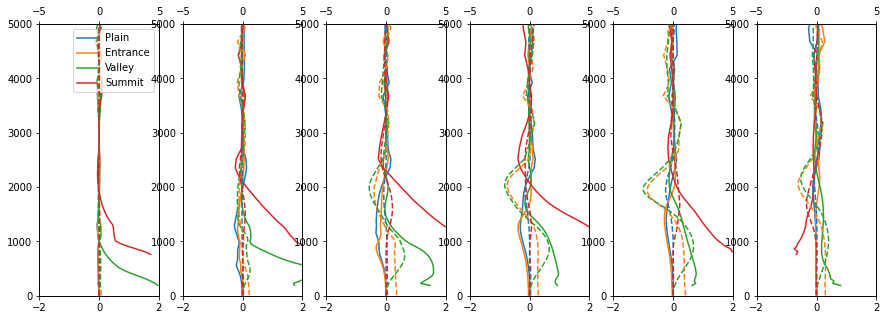

In [92]:
region_names = ["All","Plain","Entrance","Valley","Summit"]
fig,axs = plt.subplots(ncols=nt,figsize=(15,5))
for it in range(nt):
    axs[it].set_ylim((0,5000))
    axs[it].set_xlim((-2,2))
    ax_wind = axs[it].twiny()
    ax_wind.set_xlim((-5,5))
    for ireg,name in enumerate(region_names):
        if ireg>0:
            axs[it].plot(profiles[ireg,3,it]-profiles[0,3,it], Z,label=name)#
            ax_wind.plot(profiles[ireg,2,it], Z,"--")
    if it==0:
        axs[it].legend()
    #axs[it].set_xlim((308,320))
    #axs[it].set_ylim((0,5000))
    